In [1]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ROOT

from root_pandas import read_root, to_root

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from xgboost import XGBClassifier

from tqdm import tqdm
from itertools import islice

from collections import OrderedDict

from scipy.stats import linregress
from uncertainties import ufloat

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 14

# read and prepare dataset

In [3]:
data_dir = '/home/kheinicke/tank/flavourtagging/'
run_1_filenames = ['Bu2JpsiK_mu-k-e-TrainingTuple_2011_MD_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2011_MU_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2012_MD_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2012_MU_sweighted_kheinick.root',
                   ]
run_2_filenames = ['Bu2JpsiK_mu-k-e-TrainingTuple_2015_MD_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2015_MU_sweighted_kheinick.root',
#                   'Bu2JpsiK_mu-k-e-TrainingTuple_2016_MD_sweighted_kheinick.root',
#                   'Bu2JpsiK_mu-k-e-TrainingTuple_2016_MU_sweighted_kheinick.root',
                   ]
chunksize = 5000
maxslices = None

In [4]:
datasets = OrderedDict([
    ('RUNI', {
        'filenames': [data_dir + f for f in run_1_filenames],
    }),
    ('RUNII', {
        'filenames': [data_dir + f for f in run_2_filenames],
    }),
])

In [5]:
# just define some keyword arguments for read_root in a separate dict
data_kwargs = dict(
    key='DecayTree',  # the tree name
    columns=['B_OS_Muon*',  # all branches that should be read
             'B_ID',
             'B_PT',
             'runNumber',
             'eventNumber',
             'SigYield_sw',
            ],
    chunksize=chunksize,  # this will create a generator, yielding subsets with 'chunksize' of the data
    where='(B_LOKI_MASS_JpsiConstr_NoPVConstr>0)',  # a ROOT where selection, does not work with array-variables
    flatten=True  # will flatten the data in the dimension of the first given column
)

In [6]:
def get_event_number(df, weight_column='SigYield_sw'):
    """ Use weighted sums
    """
    return np.sum(df.groupby(df.event_id)[weight_column].first())  # max, min, mean, first should give the same values here

In [7]:
# Read datasets and fill several event information
for key, d in datasets.items():
    filenames = d['filenames']
    entries = 0
    for f in filenames:
        rootfile = ROOT.TFile(f)
        tree = rootfile.Get('DecayTree')
        entries += tree.GetEntries()
    datasets[key]['entries'] = entries
    if maxslices is not None and maxslices < entries/chunksize:
        total = maxslices
    else:
        total = entries/chunksize
    df = pd.concat([df for df
                    in tqdm(islice(read_root(filenames, **data_kwargs), maxslices),
                            total=total)])
    df.rename(columns=dict(zip(df.columns, [c.replace('B_OS_Muon', 'tp') for c in df.columns])), inplace=True)
    df['target'] = np.sign(df.B_ID) == np.sign(df.tp_ID)
    df['event_id'] = df.runNumber.apply(str) + '_' + df.eventNumber.apply(str)
    df['tp_ABS_RecVertexIP'] = np.abs(df.tp_RecVertexIP)
    datasets[key]['data'] = df
    datasets[key]['event_number'] = ufloat(get_event_number(df), np.sqrt(get_event_number(df)))

160it [02:35,  1.22it/s]                              
19it [00:16,  1.31it/s]                             


# apply muon-specific selections

In [8]:
# this is the list of BDT variables formerly used
classic_MVA_features = [
    'tp_partP',
    'tp_partPt',
    'tp_IPPU',
    'tp_ghostProb',
    'tp_PIDNNm',
    'tp_ABS_RecVertexIP',
    'tp_mult',
    'tp_ptB',
    'tp_IPs',
]

In [21]:
# define all the classic selections for muon tagger here for a query
queries = [
    'tp_partP > 0',
    'tp_partPt > 1.1',
    'tp_IsSignalDaughter == 0',
    'tp_minPhiDistance > 0.005',
    'tp_MuonPIDIsMuon == 1',
    'tp_partlcs < 3',
    'tp_RecVertexIP > 0',
    'tp_ghostProb < 0.4',
    'tp_PIDNNm > 0.35',
    'tp_PROBNNpi < 0.8',
    'tp_PROBNNe < 0.8',
    'tp_PROBNNk < 0.8',
    'tp_PROBNNp < 0.8',
    'tp_IPPU > 6',
#    'SigYield_sw > 0'
]
selection_features = [q.split(' ')[0] for q in queries]

In [18]:
# apply query
for key, d in datasets.items():
    df = d['data']
    selected_df = df.query(' and '.join(queries))
    selected_df.reset_index(drop=True, inplace=True)
    max_pt_df = selected_df.iloc[selected_df.groupby('event_id')['tp_partPt'].idxmax()]
    sel_event_number = ufloat(get_event_number(max_pt_df), np.sqrt(get_event_number(max_pt_df)))
    datasets[key]['selected_data'] = selected_df
    datasets[key]['event_number_selected'] = sel_event_number
    datasets[key]['max_pt_data'] = max_pt_df
    sel_efficiency = sel_event_number / datasets[key]['event_number']
    avg_omega = ufloat(np.sum(max_pt_df.SigYield_sw * ~max_pt_df.target) / np.sum(max_pt_df.SigYield_sw),
                       np.sqrt(np.sum(max_pt_df.SigYield_sw * ~max_pt_df.target)) / np.sum(max_pt_df.SigYield_sw))
    avg_tagging_power = sel_efficiency * (1 - 2 * avg_omega)**2
    print('{}:\tε:\t{}%'.format(key, sel_efficiency * 100))
    print('\t⍵:\t{}%'.format(avg_omega * 100))
    print('\tD2:\t{}%'.format((1 - 2 * avg_omega)**2 * 100))
    print('\tε_eff:\t{}%'.format(avg_tagging_power * 100))

RUNI:	ε:	5.448+/-0.028%
	⍵:	31.45+/-0.28%
	D2:	13.8+/-0.4%
	ε_eff:	0.750+/-0.023%
RUNII:	ε:	6.71+/-0.09%
	⍵:	35.2+/-0.8%
	D2:	8.8+/-0.9%
	ε_eff:	0.59+/-0.06%


In [15]:
df = datasets['RUNI']['data']
evt_num = datasets['RUNI']['event_number']
efficiencies = []
e_effs = []
ippu_cuts = np.linspace(2.5, 10, 20)
for ippu_cut in tqdm(ippu_cuts):
    qs = queries[:-1] + ['tp_IPPU > ' + str(ippu_cut)]
    selected_df = df.query(' and '.join(qs))
    selected_df.reset_index(drop=True, inplace=True)
    max_pt_df = selected_df.iloc[selected_df.groupby('event_id')['tp_partPt'].idxmax()]
    efficiency = get_event_number(max_pt_df) / evt_num.n
    efficiencies.append(efficiency)
    omega = np.average(~max_pt_df.target, weights=max_pt_df.SigYield_sw)
    e_effs.append(efficiency * (1 - 2 * omega)**2)
efficiencies = np.array(efficiencies)
e_effs = np.array(e_effs)

100%|██████████| 20/20 [01:14<00:00,  3.84s/it]


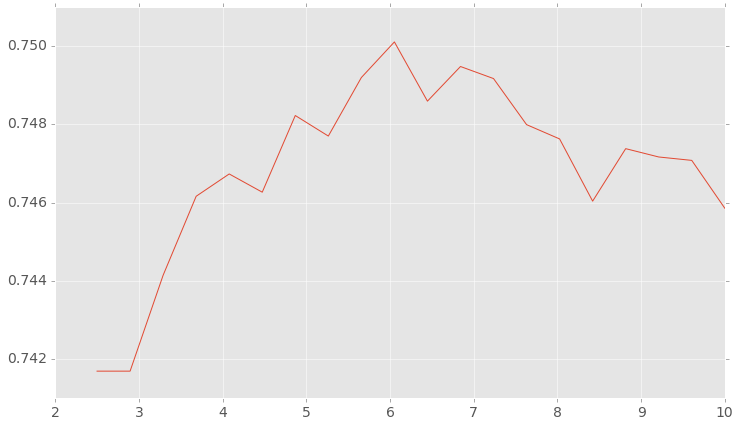

In [16]:
# plt.plot(ippu_cuts, 100 * efficiencies)
plt.plot(ippu_cuts, 100 * e_effs)
plt.show()

In [43]:
train_data, test_data, train_labels, test_labels = train_test_split(df, df.target, test_size=0.5)

In [65]:
selection_model = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=300, nthread=24)

In [66]:
selection_model.fit(train_data[selection_features], train_labels)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=300, nthread=24,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [67]:
probas = selection_model.predict_proba(test_data[selection_features])[:,1]
score = roc_auc_score(test_labels, probas)

In [69]:
cuts = np.linspace(0.05, 0.95, 20)
num = get_event_number(test_data)
efficiencies = np.array([get_event_number(test_data[probas > c]) / num for c in cuts])
eps_effs = []
for c, eff in zip(cuts, efficiencies):
    try:
        omega = np.average(~test_data[probas > c].target, weights=test_data[probas > c].SigYield_sw)
    except:
        omega = 0.5
    eps_effs.append(eff * (1 - 2 * omega)**2)
eps_effs = np.array(eps_effs)

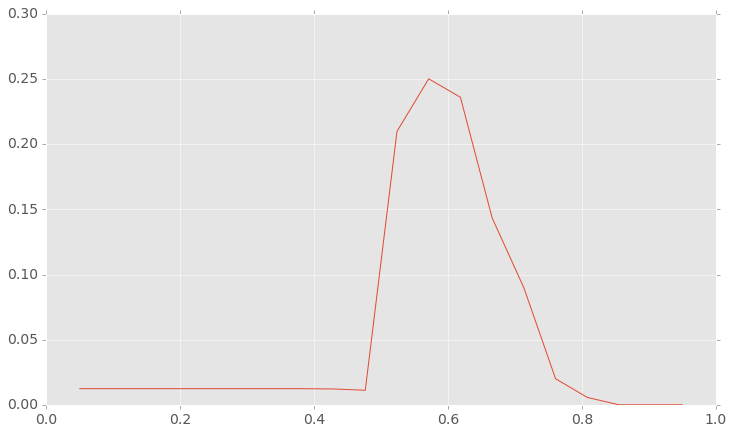

In [71]:
plt.plot(cuts, 100 * eps_effs)
plt.show()

# train the classifier

In [836]:
# split data, label and sWeights into train- and test-data
(train_data, test_data,
 train_labels, test_labels,
 train_weights, test_weights) = train_test_split(max_pt_data, max_pt_data.target,
                                                 max_pt_data.SigYield_sw, train_size=0.5)

In [837]:
np.sum(test_weights * (test_labels == False)) / get_event_number(test_data)

0.3323877885169882

In [770]:
xgb_model = XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.01, nthread=32, seed=1)

In [771]:
# train with sWeights > 0 data
sWeight_cut = train_weights > -1000
xgb_model.fit(train_data[sWeight_cut][classic_MVA_features],
              train_labels[sWeight_cut],
              sample_weight=train_weights[sWeight_cut])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=32,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=True, subsample=1)

In [772]:
# right-tag prediction
probas = xgb_model.predict_proba(test_data[classic_MVA_features])[:, 1]
probas_train = xgb_model.predict_proba(train_data[classic_MVA_features])[:, 1]

In [773]:
# store the roc auc scores on training and test sample
auc_score = roc_auc_score(test_labels, probas, sample_weight=test_weights)
auc_score_train = roc_auc_score(train_labels, probas_train, sample_weight=train_weights)

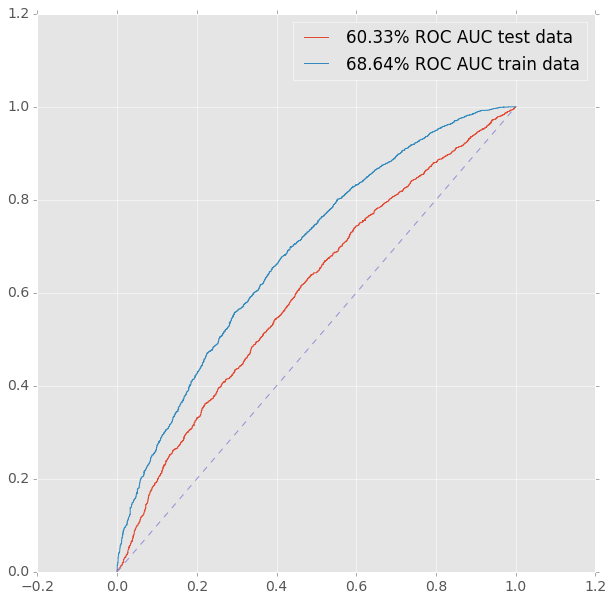

In [774]:
# plot both
plt.figure(figsize=(10, 10))
plt.plot(*roc_curve(test_labels, probas, sample_weight=test_weights)[:2],
         label='{:2.2f}% ROC AUC test data'.format(100 * auc_score))
plt.plot(*roc_curve(train_labels, xgb_model.predict_proba(train_data[classic_MVA_features])[:, 1],
                    sample_weight=train_weights)[:2],
         label='{:2.2f}% ROC AUC train data'.format(100 * auc_score_train))
plt.plot([0, 1], '--')
plt.legend(loc='best')
plt.show()

In [775]:
def d2_score(y_score, sample_weight=None):
    D2s = (1 - 2 * y_score)**2
    return np.average(D2s, weights=sample_weight)

def tagging_power_score(y_true, y_score, sample_size, sample_weight=None):
    """Compute per event tagging power
    """
    if sample_weight is not None:
        num_tags = np.sum(sample_weight)
    else:
        num_tags = len(y_score)
    return num_tags / sample_size * d2_score(y_score, sample_weight)

In [777]:
power_score = tagging_power_score(test_labels, probas, 0.5 * get_event_number(df), sample_weight=test_weights)
d2 = d2_score(probas, sample_weight=test_weights)
print('Uncalibrated, sWeighted per event tagging power: {:.2f}%\nD2: {:.2f}'.format(100 * power_score, d2))

Uncalibrated, sWeighted per event tagging power: 0.54%
D2: 0.13


In [778]:
def error_hist(x, bins=30, normed=False, weights=None, density=None, fmt='.', **kwargs):
    y, bin_edges = np.histogram(x, bins=bins, normed=normed, weights=weights, density=density)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    plt.errorbar(bin_centers, y, np.sqrt(y), fmt=fmt, **kwargs)
    return plt

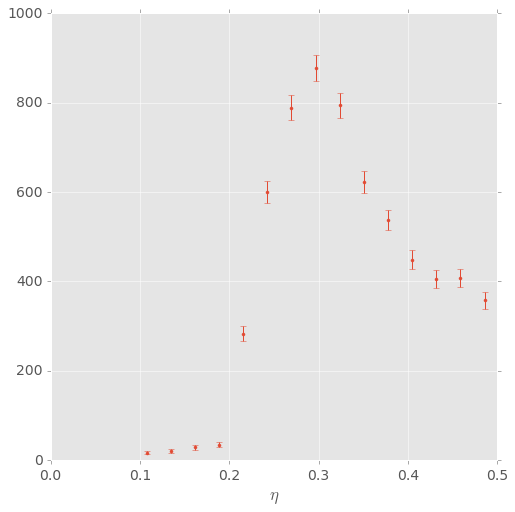

In [856]:
# store etas (if prediction > 0.5, eta is 1 - prediction, otherwise eta is prediction)
etas = np.where(probas >= 0.5, 1 - probas, probas)

# plot something! here is the eta distribution
plt.figure(figsize=(8, 8))
error_hist(etas, bins=15, label=r'$\eta$ predictions')
plt.xlim(0, 0.5)
plt.xlabel(r'$\eta$')
plt.show()

# calibrate $\eta$

In [780]:
def omega(eta, p0, p1):
    """ linear calibration function
    """
    # return eta + p0 + p1 * (eta - eta.mean())
    return p0 + p1 * eta

def omega_poly(eta, *args):
    return np.sum([np.array(eta)**i * p for i, p in enumerate(args)], axis=0)

def d_omega_poly(eta, cov, *args):
    B = np.array([np.array(eta)**i for i, p in enumerate(args)]).T
    return np.array([np.dot(B[i], np.dot(cov, B[i].T)) for i in range(len(B))])

def Pbb(eta, p0, p1, predicted_labels):
    """ probability distribution for correct predictions
    """
    p = omega(eta, p0, p1)
    return np.where(predicted_labels, 1 - p, p)

def Pbb_poly(eta, *args):
    eta = np.where(eta > 0.5, 1 - eta, eta)
    return omega_poly(eta, *args)

In [781]:
from scipy.optimize import curve_fit

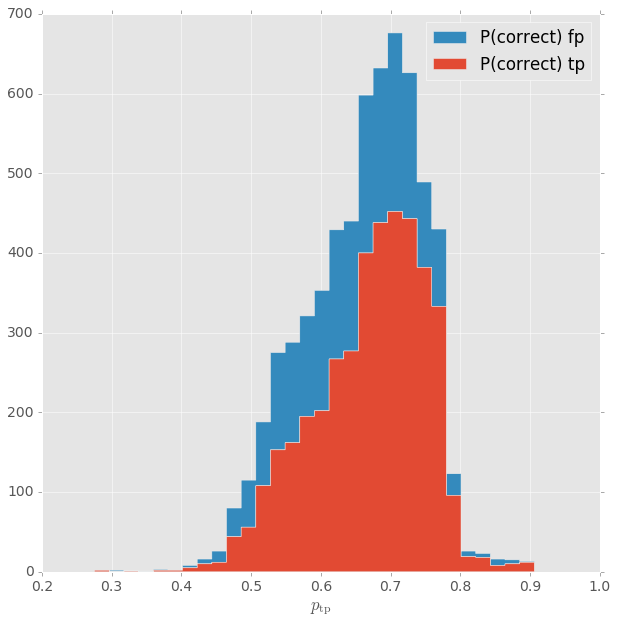

In [782]:
plt.figure(figsize=(10, 10))
p0, p1 = 0, 1
plt.hist([Pbb(etas, p0, p1, probas > 0.5)[test_labels.values],
          Pbb(etas, p0, p1, probas > 0.5)[~test_labels.values]],
         histtype='stepfilled', bins=30, rwidth=1, stacked=True,
         label=['P(correct) tp', 'P(correct) fp'])
plt.xlabel(r'$p_\mathrm{tp}$')
plt.legend(loc='best')
plt.show()

In [783]:
params, cov = curve_fit(lambda x, a, b: Pbb(x, a, b, test_labels),
                        etas, probas > 0.5, maxfev=5000, p0=[0, 1])

In [849]:
# params_poly, cov_poly = curve_fit(lambda x, p0, p1, p2, p3: Pbb_poly(x, test_labels, p0, p1, p2, p3),
#                                   etas, probas > 0.5, maxfev=10000)
binned_data = proba_bins(etas, test_labels == False, range=(0, 0.5), sample_weight=test_weights, bins=20)
nas = np.isnan(binned_data[1])
xs, ys, sigmas = binned_data[0][~nas], binned_data[1][~nas], binned_data[2][~nas], 
params_poly, cov_poly = curve_fit(lambda x, p0, p1, p2: Pbb_poly(x, p0, p1, p2),
                                  xs, ys, maxfev=10000, sigma=sigmas)
errors_poly = np.sqrt(np.diag(cov_poly))

In [850]:
print(*[ufloat(v, u) for v, u in zip(params_poly, errors_poly)], sep='\n')

0.22+/-0.09
0.6+/-0.5
-0.8+/-0.8


In [851]:
p0, p1 = params
p0err, p1err = np.diag(np.sqrt(cov))
print('p0 = {}, p1 = {}'.format(ufloat(p0, p0err), ufloat(p1, p1err)))
print('Cov:\n', cov)

p0 = 0.026+/-0.026, p1 = 0.94+/-0.08
Cov:
 [[ 0.00068091 -0.00192233]
 [-0.00192233  0.00572308]]


In [852]:
params_p, cov_p = curve_fit(omega, probas, test_labels, p0=[0, 1], maxfev=10000)

In [853]:
err_p = np.sqrt(np.diag(cov_p))
print(ufloat(params_p[0], err_p[0]),
      ufloat(params_p[1], err_p[1]))
print('Cov:\n', cov_p)

0.63+/-0.05 0.05+/-0.07
Cov:
 [[ 0.00232863 -0.00346531]
 [-0.00346531  0.0052385 ]]


In [789]:
def proba_bins(x, y_true, errs=True, bins=10, range=(0, 1), sample_weight=None):
    """ Bin data by x and calculate the amount of y_true in each bin,
        errors will be (bin_width/2, sqrt(bin_count))
    """
    if sample_weight is None:
        sample_weight = np.ones(x.shape)
    stepsize = (range[1] - range[0]) / bins
    bin_range = np.arange(range[0], range[1], stepsize)
    xs = np.array([x_ + stepsize/2 for x_ in bin_range])
    true_sums = np.array([np.sum(sample_weight[(x > x_) & (x <= x_+stepsize)]) for x_ in bin_range])
    ys = np.array([np.sum(sample_weight[(x > x_) & (x <= x_+stepsize) & (np.array(y_true) == True)])
          for x_ in bin_range]) / true_sums
    if errs:
        y_errs = np.array([np.sqrt(np.sum(sample_weight[(x > x_) & (x <= x_+stepsize) & (np.array(y_true) == False)]))
                  for x_ in bin_range]) / true_sums
        x_errs = stepsize / 2
        return xs, ys, y_errs, x_errs
    else:
        return xs, ys

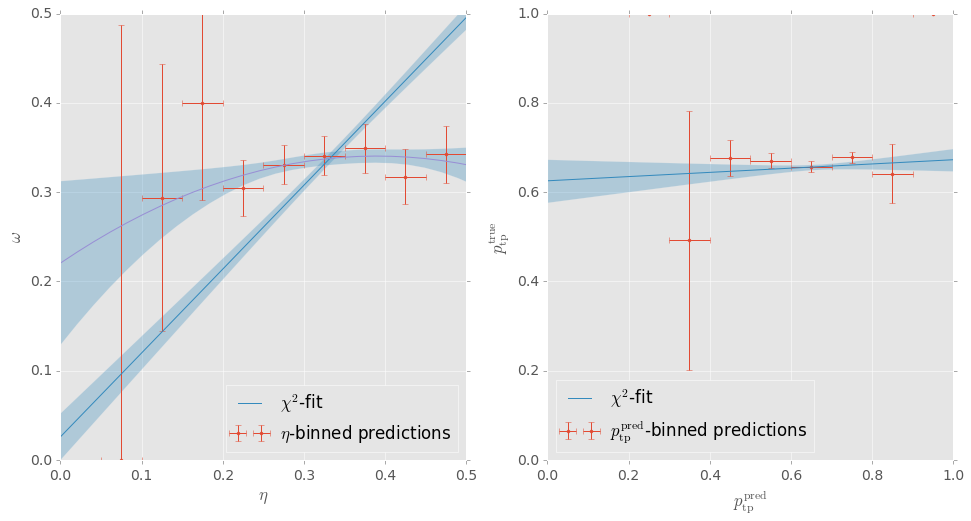

In [854]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.errorbar(*proba_bins(etas, test_labels == False, range=(0, 0.5), sample_weight=test_weights),
             fmt='.', label=r'$\eta$-binned predictions')
xs = np.linspace(0, 1)
plt.plot(xs, omega(xs, *params), label=r'$\chi^2$-fit')
plt.fill_between(xs, 
                 omega_poly(xs, *params) - np.sqrt(d_omega_poly(xs, cov, *params)),
                 omega_poly(xs, *params) + np.sqrt(d_omega_poly(xs, cov, *params)),
                 alpha=0.3)
plt.plot(xs, omega_poly(xs, *params_poly))
plt.fill_between(xs, 
                 omega_poly(xs, *params_poly) - np.sqrt(d_omega_poly(xs, cov_poly, *params_poly)),
                 omega_poly(xs, *params_poly) + np.sqrt(d_omega_poly(xs, cov_poly, *params_poly)),
                 alpha=0.3)
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\omega$')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.errorbar(*proba_bins(probas, test_labels, range=(0, 1), sample_weight=test_weights),
             fmt='.', label=r'$p_\mathrm{tp}^\mathrm{pred}$-binned predictions')
xs = np.linspace(0, 1)
plt.plot(xs, omega(xs, *params_p), label=r'$\chi^2$-fit')
plt.fill_between(xs,
                 omega_poly(xs, *params_p) - np.sqrt(d_omega_poly(xs, cov_p, *params_p)),
                 omega_poly(xs, *params_p) + np.sqrt(d_omega_poly(xs, cov_p, *params_p)),
                 alpha=0.3)
plt.xlabel(r'$p_\mathrm{tp}^\mathrm{pred}$')
plt.ylabel(r'$p_\mathrm{tp}^\mathrm{true}$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

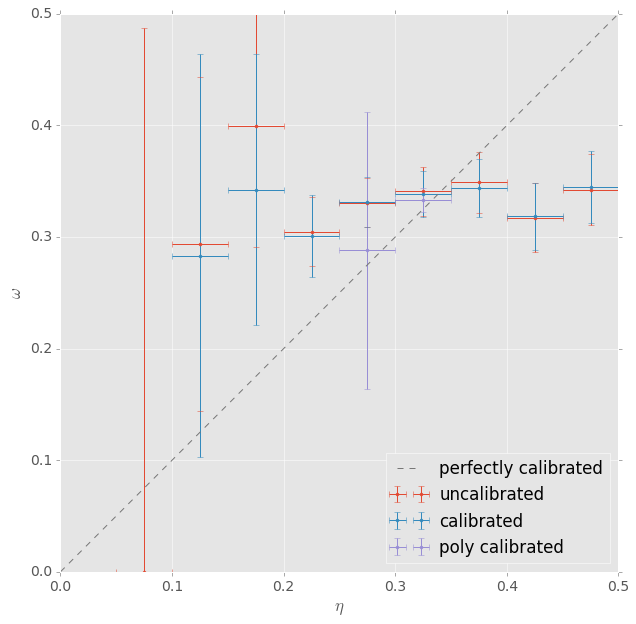

In [855]:
calibrated_etas = omega(etas, *params)
poly_calibrated_etas = omega_poly(etas, *params_poly)
plt.figure(figsize=(10, 10))
plt.errorbar(*proba_bins(etas, test_labels == False, range=(0, 0.5), sample_weight=test_weights),
             fmt='.', label='uncalibrated')
plt.errorbar(*proba_bins(calibrated_etas, test_labels == False, range=(0, 0.5), sample_weight=test_weights),
             fmt='.', label='calibrated')
plt.errorbar(*proba_bins(poly_calibrated_etas, test_labels == False, range=(0, 0.5), sample_weight=test_weights),
             fmt='.', label='poly calibrated')
plt.plot([0, 0.5], [0, 0.5], '--', label='perfectly calibrated')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.legend(loc='best')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\omega$')
plt.show()

In [869]:
# tagging power is even worse, obviously the simple linear calibration is not approprate here
tagging_power_score(test_labels, calibrated_etas, 0.5 * get_event_number(df), sample_weight=test_weights) * 100

0.50698604207927889

In [870]:
from scripts.utils import bootstrap_calibrate_prob
D2s, aucs = bootstrap_calibrate_prob(max_pt_data.target, max_pt_data.SigYield_sw,
                                     xgb_model.predict_proba(max_pt_data[classic_MVA_features])[:,1])

In [871]:
np.mean(D2s)

0.16551012368092832

In [872]:
d2_score(poly_calibrated_etas, sample_weight=test_weights)

0.11169968763742212

In [873]:
tagging_power_score(test_labels, etas, 0.5 * get_event_number(df), sample_weight=test_weights) * 100

0.54843754883174334

In [874]:
tagging_power_score(test_labels, poly_calibrated_etas, 0.5 * get_event_number(df), sample_weight=test_weights) * 100

0.46034211890261234